### AutoEncoder를 활용한 이상탐지

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from scipy import stats
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

%matplotlib inline

sns.set(style="whitegrid", palette="muted", font_scale=1.5)
rcParams["figure.figsize"] = 14, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

### 간단한 데이터 탐색

In [2]:
# dataset download at https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud 
df = pd.read_csv("./Data/creditcard.csv")

In [3]:
df.shape

(284807, 31)

In [4]:
df.isnull().values.any()

False

Text(0, 0.5, 'Frequency')

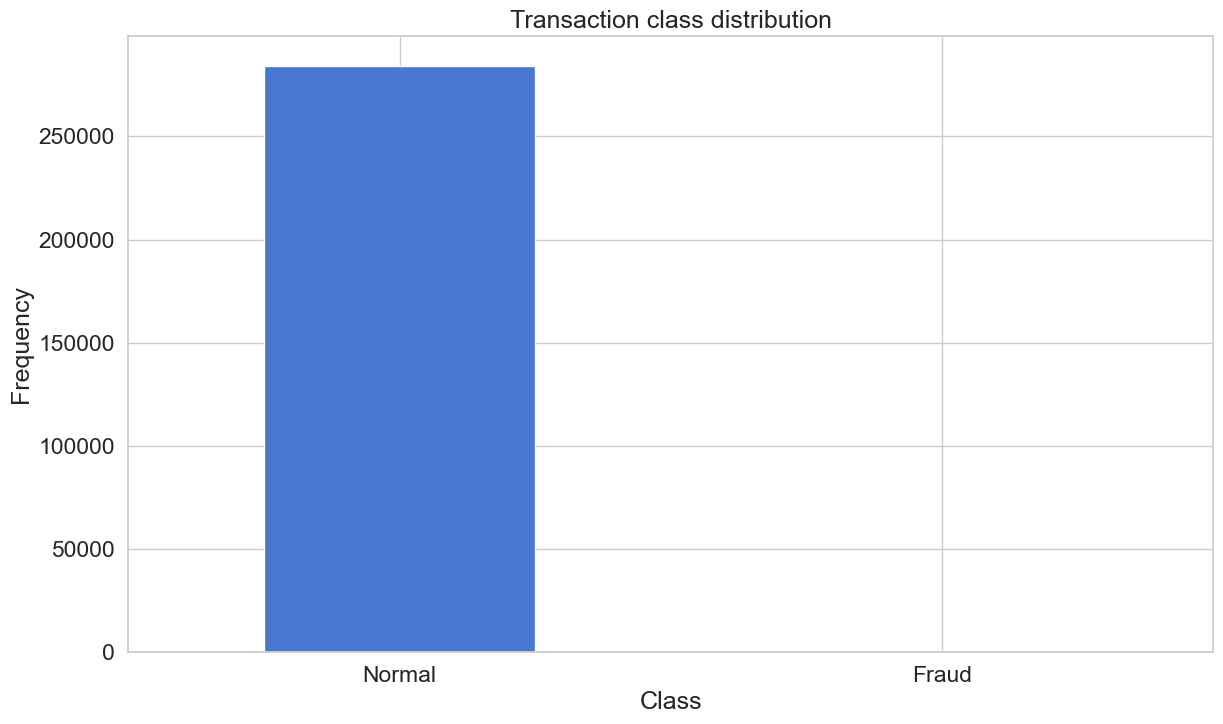

In [5]:
# 비정상 데이터와 정상 데이터의 비율
count_classes = df["Class"].value_counts()
count_classes.plot(kind="bar", rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")

비정상 데이터에 비해 정상 데이터가 압도적으로 많은 것을 확인할 수 있다.

In [6]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]
frauds.shape

(492, 31)

In [7]:
normal.shape

(284315, 31)

각 라벨 별 Amount 컬럼에 대한 탐색

In [8]:
frauds.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [9]:
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

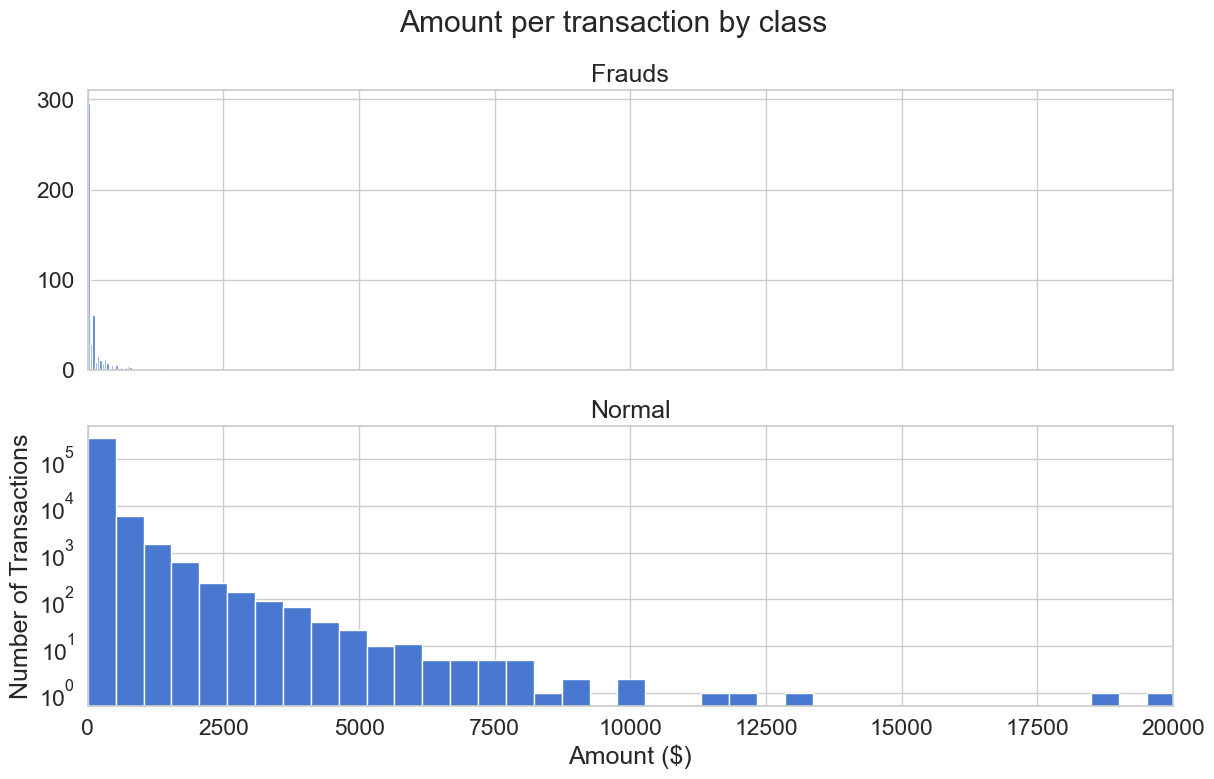

In [10]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle("Amount per transaction by class")

bins = 50

ax1.hist(frauds.Amount, bins = bins)
ax1.set_title("Frauds")

ax2.hist(normal.Amount, bins=bins)
ax2.set_title("Normal")

plt.xlabel("Amount ($)")
plt.ylabel("Number of Transactions")
plt.xlim((0, 20000))
plt.yscale("log")
plt.show()

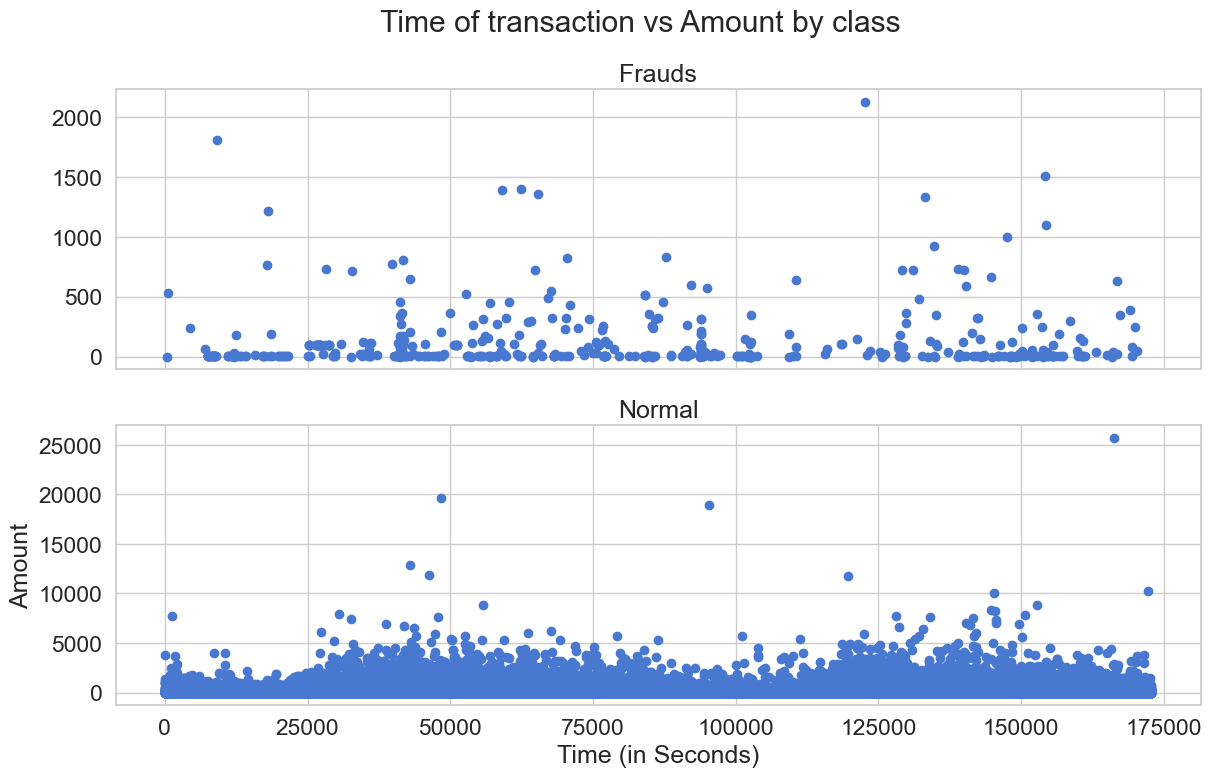

In [11]:
# 각 라벨 별 시간에 따른 거래액
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle("Time of transaction vs Amount by class")

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title("Frauds")

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title("Normal")

plt.xlabel("Time (in Seconds)")
plt.ylabel("Amount")
plt.show()

## Auto Encoder

AutoEncoder는 원래의 데이터를 하나의 특징으로 압축시킨 후, 원래의 형태로 복원시키는 비지도학습 방법 중 하나이다.

<div align=center><img src="./image_for_markdown/AutoEncoder.png"></div>

NLP에서 보던 seq2seq모델과도 구조가 많이 닮은 모습이다. 크게 encoder, decoder, Latent Representation으로 구성되어 있으며, Encoder는 입력된 데이터를 Latent Representation이라는 하나의 벡터로 압축시킨다.
이 떄, Latent Representation는 입력 데이터보다 차원 수가 낮다.

Decoder는 압축된 Latent Representation을 원래의 차원으로 복구시킨다. 이 때 우리의 목적은 Dimensionality Reduction이다. 

## AutoEncoder in image
28*28 의 이미지를 Flatten하여 784 길이의 벡터로 만들어서 입력으로 사용한다. Encoder에서는 세 번에 걸쳐서 데이터의 차원을 압축한다. (784 $\rarr$ 500, 500 $\rarr$ 300, 300 $\rarr$ 2)

따라서 Latent Representation은 2차원 벡터로 구성된다. 이를 수식으로 나타내면 아래와 같다.

- 입력 데이터의 차원 정보 : $D$
- Latent Dimension : $d$
- 입력 데이터 : $(x_1, x_2, ... , x_D)$
- Latent Representation : $(z_1, z_2, ..., z_d)$
- 출력 데이터 : $(x'_1, x'_2, ..., x'_D)$
- encoder : $z = f(x)$
- decoder : $x' = g(z)$

## Auto Encoder의 활용

- AutoEncoder가 무난히 잘 학습되었다면 Latent Representation으로부터 원본 데이터와 최대한 유사하게 데이터를 복구할 수 있기에 데이터 생성 기법으로도 사용될 수 있다.
    + 학습된 AutoEncoder에서 Decoder부분만 사용하여서 임의의 Latent Representation을 입력하여 새로운 데이터를 얻어내는 방식인 셈이다.
    + 단, 원본 데이터의 차원 수가 커질 수록 AutoEncoder가 모든 데이터 분포에 대해서 완전히 학습하기 힘들기 때문에, 의미없는 데이터가 생성될 위험성을 지니고 있다.

- AutoEncoder가 잘 학습되었다면 Latent Representation가 데이터의 중요 특징을 잘 설명하고 있기에 차원 감소 기법으로도 사용할 수 있다.
    + 학습된 AutoEncoder에서 Encoder부분만 사용하여서 계산된 Latent Representation만을 사용하는 것이다. 
    + 대표적인 차원 감소 기법인 주성분분석(PCA)은 선형적 기법인 반면에 AutoEncoder는 비선형적인 차원 감소 기법이다.

## Reconstruction Error
AutoEncoder의 모델을 학습시키며 제일 주된 목적 중 하나는 오류가 최소화 되도록 최적화하는 것이다. 이 때 쓰이는 학습 오류는 조금 특별한 종류인데, 재구성 오류이다. 아래와 같은 제곱식으로 나타낸다.

$L(x, x') = \parallel x - x' \parallel ^2$

In [12]:
from sklearn.preprocessing import StandardScaler

data = df.drop(["Time"], axis=1)
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

In [13]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(["Class"], axis=1)

y_test = X_test['Class']
X_test = X_test.drop(["Class"], axis=1)

X_train = X_train.values
X_test = X_test.values

X_train.shape

(227451, 29)

In [14]:
input_dim = X_train.shape[1]
encoding_dim = 14

input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim/2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim/2), activation="relu")(encoder)
decoder = Dense(input_dim, activation = "relu")(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [15]:
nb_epoch = 100
batch_size = 32
autoencoder.compile(optimizer="adam", loss="mean_squared_error", metrics=["acc"])

cp = ModelCheckpoint(filepath="./model/model.h5", verbose=0, save_best_only=True)
tensorboard = TensorBoard(log_dir="./model/logs", histogram_freq=0, write_graph=True, write_images=True)

history = autoencoder.fit(X_train, X_train, epochs=nb_epoch, batch_size=batch_size, shuffle=True, validation_data=(X_test, X_test), verbose=1, callbacks=[cp, tensorboard]).history

Epoch 1/100
7108/7108 [==============================] - 38s 5ms/step - loss: 0.8416 - acc: 0.5498 - val_loss: 0.8216 - val_acc: 0.6343
Epoch 2/100
7108/7108 [==============================] - 39s 6ms/step - loss: 0.7870 - acc: 0.6411 - val_loss: 0.8098 - val_acc: 0.6518
Epoch 3/100
7108/7108 [==============================] - 40s 6ms/step - loss: 0.7799 - acc: 0.6510 - val_loss: 0.8016 - val_acc: 0.6630
Epoch 4/100
7108/7108 [==============================] - 39s 6ms/step - loss: 0.7667 - acc: 0.6766 - val_loss: 0.7894 - val_acc: 0.6902
Epoch 5/100
7108/7108 [==============================] - 40s 6ms/step - loss: 0.7603 - acc: 0.6884 - val_loss: 0.7869 - val_acc: 0.6927
Epoch 6/100
7108/7108 [==============================] - 39s 6ms/step - loss: 0.7582 - acc: 0.6884 - val_loss: 0.7850 - val_acc: 0.6944
Epoch 7/100
7108/7108 [==============================] - 39s 6ms/step - loss: 0.7573 - acc: 0.6876 - val_loss: 0.7852 - val_acc: 0.6879
Epoch 8/100
7108/7108 [=========================

In [16]:
autoencoder = load_model("./model/model.h5")

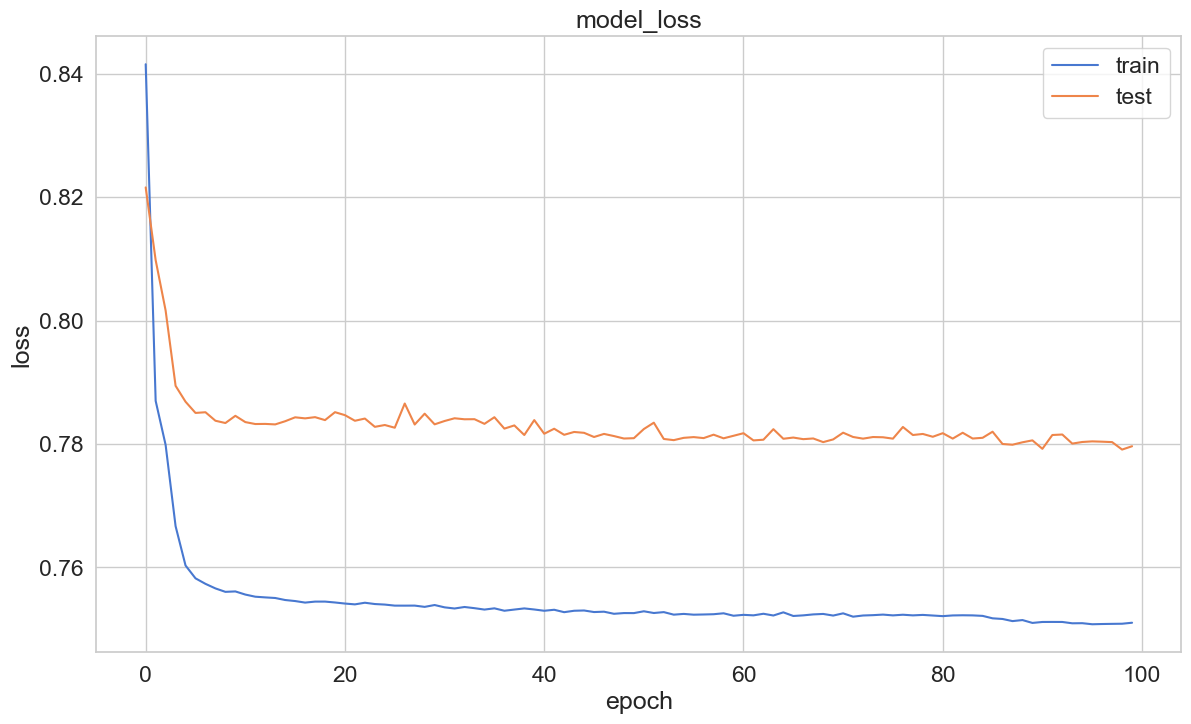

In [17]:
# Training Curve 가시화
plt.plot(history["loss"])
plt.plot(history["val_loss"])
plt.title("model_loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper right")

In [18]:
predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)  # reconstruction error
error_df = pd.DataFrame({"reconstructure" : mse, "true_class": y_test })

error_df.describe()

1781/1781 [==============================] - 2s 1ms/step


,reconstructure,true_class
count,56962.000000,56962.000000
mean,0.778199,0.001720
std,3.497009,0.041443
min,0.032780,0.000000
25%,0.233381,0.000000
50%,0.393880,0.000000
75%,0.634234,0.000000
max,252.867971,1.000000


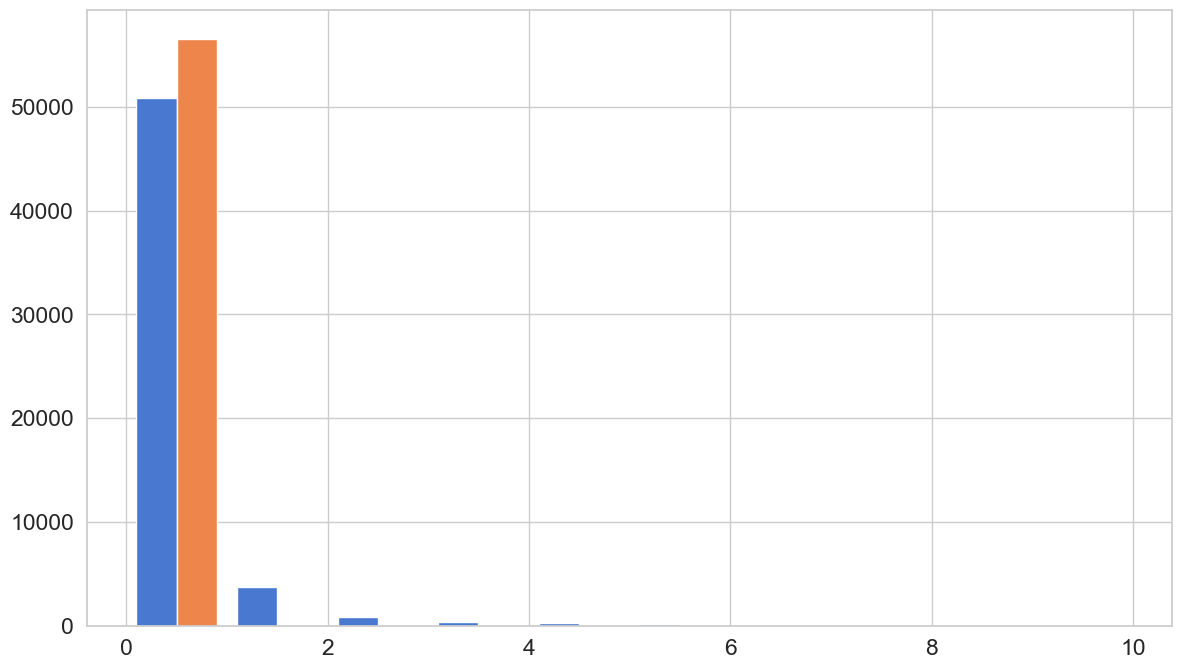

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df["true_class"] == 0) & (error_df['reconstructure'] < 10)]
_ = ax.hist(normal_error_df)

## ROC 곡선을 통한 평가

<div align=center><img src="./image_for_markdown/roc_curve.PNG"></div>

ROC Curve의 경우 이진 분류기를 평가하는데 가장 유용하게 사용하는 지표이다. 해당 지표의 경우 True Positive Rate(TPR), False Positive Rate(FPR)로 표현한다.

좀 더 단순하게 얘기하면, 곡선이 왼쪽 위에 위치할수록 좋은 성능을 띤다는 것이다.

- 1. TPR, FPR
    + 두 개의 공통적인 부분인 Positive는, 판단자가 "그렇다"라고 판단했음을 의미한다. True와 False에 따라 그 결과가 달라진다. 특정 병에 걸려서 병원을 방문한 인원을 예시로, 실제로 병에 걸렸는데 의사가 병에 걸렸다고 판단하는 경우가 TPR, 병에 걸리지 않았는데 병에 걸렸다고 판단하는 경우가 FPR인 것이다. 

- 2. threshold와 TPR, FPR
    + 의사가 어느날 너무 귀찮아서 **모든 환자들을 그냥 모두 병에 걸린 사람**으로 판단했다면, TPR과 FPR이 동시에 높아질 것이며, 반대의 경우엔 TPR과 FPR이 동시에 낮아질 것이다.

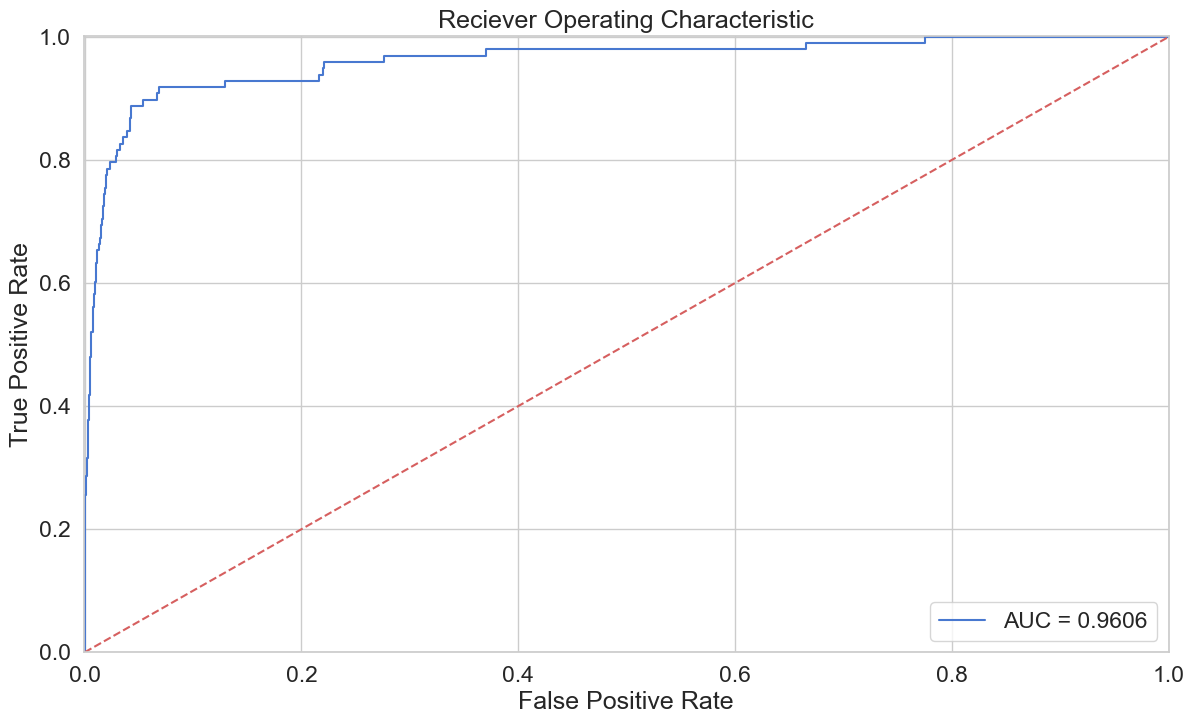

In [21]:
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_curve, recall_score, classification_report, f1_score, precision_recall_fscore_support

fpr, tpr, threshold = roc_curve(error_df.true_class, error_df.reconstructure)
roc_auc = auc(fpr, tpr)

plt.title("Reciever Operating Characteristic")
plt.plot(fpr, tpr, label="AUC = {}".format(round(roc_auc, 4)))
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()